In [1]:
# Import libraries
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error  # Ensure this import is included
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import boxcox
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap

In [2]:
# Set up figures' format
%config InlineBackend.figure_format = 'retina'

In [3]:
# Importing dataset
syd,preds = pd.read_csv('syd_17.csv'), pd.read_csv('syd_17_preds.csv')

In [4]:
income = syd['income']
id = preds['id']

In [5]:
# Rescaling procedure
first_col = syd.iloc[:, 0]
remaining_cols = syd.iloc[:, 1:]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the remaining columns of X and transform them
remaining_scaled = pd.DataFrame(scaler.fit_transform(remaining_cols), columns=remaining_cols.columns)

# Reset indices to ensure they align for concatenation
first_col = first_col.reset_index(drop=True)
remaining_scaled = remaining_scaled.reset_index(drop=True)

# Concatenate the first column back with the scaled remaining columns
syd = pd.concat([first_col, remaining_scaled], axis=1)

# Print the final DataFrame with the unscaled first column and scaled remaining columns
print(syd)


      income  surface_structure_coherence_mean  \
0         31                          0.734941   
1        110                          0.830092   
2        176                          0.482333   
3        240                          0.767768   
4        380                          0.651340   
...      ...                               ...   
9411    4513                          0.711447   
9412    4523                          0.548892   
9413    4596                          0.675843   
9414    4666                          0.552867   
9415    4750                          0.651223   

      surface_structure_disorderliness_mean  \
0                                  0.300280   
1                                  0.399101   
2                                  0.155683   
3                                  0.226679   
4                                  0.415478   
...                                     ...   
9411                               0.344419   
9412                   

In [6]:
# Rescaling procedure

first_col = preds.iloc[:, 0]
remaining_cols = preds.iloc[:, 1:]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the remaining columns of X and transform them
remaining_scaled = pd.DataFrame(scaler.fit_transform(remaining_cols), columns=remaining_cols.columns)

# Reset indices to ensure they align for concatenation
first_col = first_col.reset_index(drop=True)
remaining_scaled = remaining_scaled.reset_index(drop=True)

# Concatenate the first column back with the scaled remaining columns
preds = pd.concat([first_col, remaining_scaled], axis=1)

# Print the final DataFrame with the unscaled first column and scaled remaining columns
print(preds)


        id  surface_structure_coherence_mean  \
0      505                          0.734941   
1      632                          0.830092   
2      432                          0.482333   
3      798                          0.767768   
4     1667                          0.651340   
...    ...                               ...   
9411  9205                          0.711447   
9412  8959                          0.548892   
9413  9670                          0.675843   
9414  9269                          0.552867   
9415  9690                          0.651223   

      surface_structure_disorderliness_mean  \
0                                  0.300280   
1                                  0.399101   
2                                  0.155683   
3                                  0.226679   
4                                  0.415478   
...                                     ...   
9411                               0.344419   
9412                               0.300637   


In [7]:
# Creating X and y dataframes
y = syd.income
X = preds.drop('id', axis=1)

In [8]:
# Split the subsetted data into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
dataset_dir = './inc_syd'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# We will be able to work with files with/without header and
# with different separators.

syd.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)
preds.to_csv(
    os.path.join(dataset_dir, 'preds.csv'),
    index=False, sep=',', header=True
)

In [10]:
pool1 = Pool(data=X, label=y)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 

Dataset shape
dataset 1:(9416, 17)


Column names
dataset 1:
['surface_structure_coherence_mean', 'surface_structure_disorderliness_mean', 'surface_roughness_disorderliness_mean', 'colour_saturation_mean', 'colour_hue_coherence_mean', 'colour_hue_disorderliness_mean', 'tcap_wetness_mean', 'tcap_greenness_std', 'nir_band_mean', 'colour_brightness_coherence_mean', 'colour_brightness_disorderliness_mean', 'ndwi_wetness_contrast_mean', 'ndwi_wetness_coherence_std', 'tcap_wetness_disorderliness_mean', 'tcap_built_coherence_std', 'x_coord', 'y_coord']


TBB Warning: The number of workers is currently limited to 5. The request for 39 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



In [11]:
# Train/validation split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

In [12]:
# Fitting CatBoost model
best_model = CatBoostRegressor(
    random_seed=63,
    iterations=1300,
    task_type="CPU",
    learning_rate=0.03,
    l2_leaf_reg = 60,
    depth = 3,
    loss_function='MAE'
)
best_model.fit(
    X_train, y_train,
    verbose=False,
    eval_set=(X_validation, y_validation),
    early_stopping_rounds=50,
    plot=False
)
results = best_model.get_evals_result()

Pearson correlation coefficient: 0.7612931660873566
Spearman correlation coefficient: 0.7766398234157363


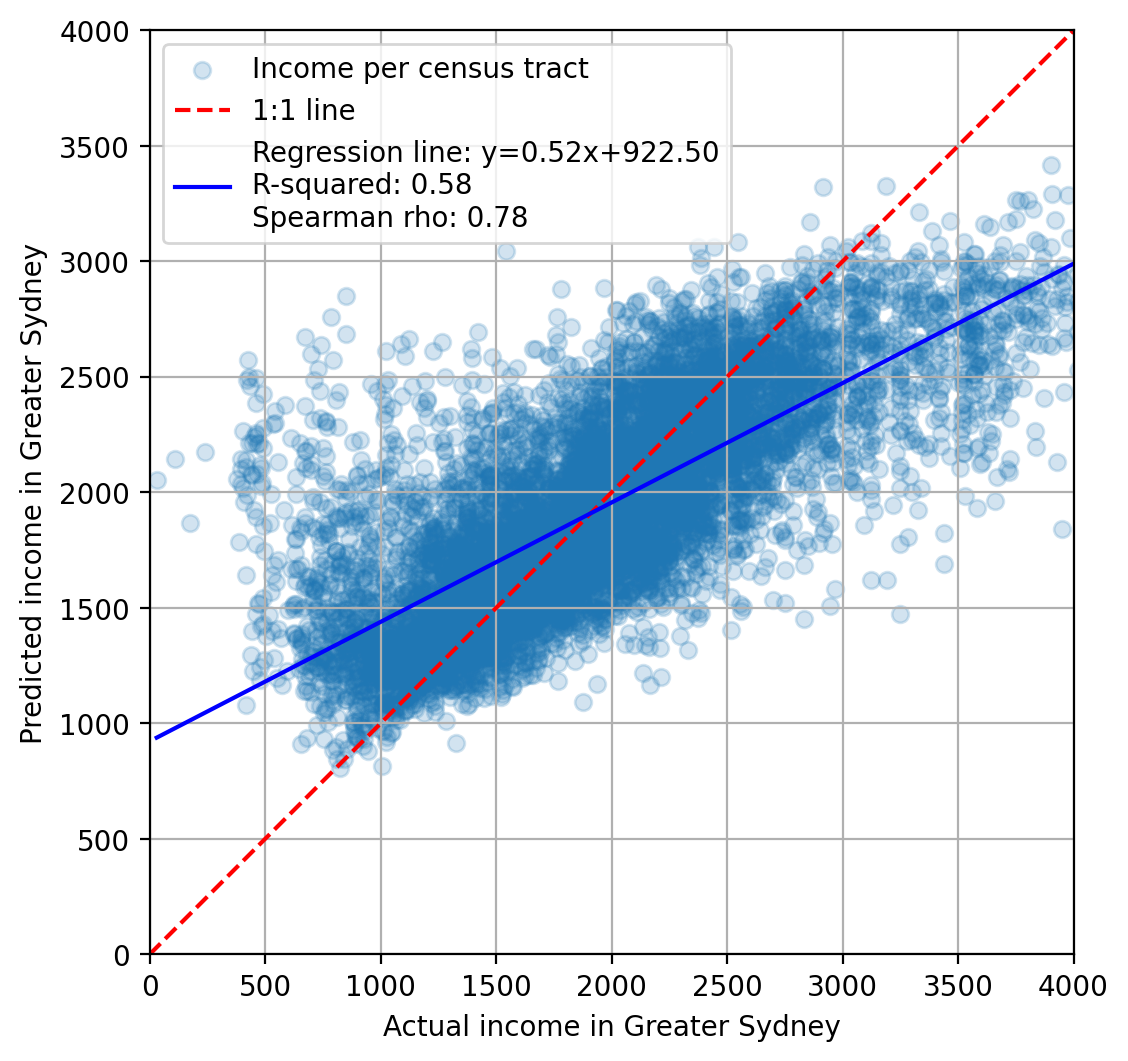

In [13]:
# Make predictions using the CatBoost model
predicted_values = best_model.predict(X)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y.values.flatten(),  # Assuming y is a single-column DataFrame
    'Predicted': predicted_values
})

# Calculate Pearson's correlation coefficient
pearson_corr, _ = pearsonr(results_df['Actual'], results_df['Predicted'])
print(f'Pearson correlation coefficient: {pearson_corr}')

# Calculate Spearman's correlation coefficient
spearman_corr, _ = spearmanr(results_df['Actual'], results_df['Predicted'])
print(f'Spearman correlation coefficient: {spearman_corr}')

# Perform linear regression
reg_model = LinearRegression()
reg_model.fit(results_df[['Actual']], results_df['Predicted'])
predicted_reg = reg_model.predict(results_df[['Actual']])

# Calculate R-squared value
r_squared = r2_score(results_df['Predicted'], predicted_reg)

# Get regression parameters
slope = reg_model.coef_[0]
intercept = reg_model.intercept_

# Plotting scatter plot with regression line
plt.figure(figsize=(6, 6))
plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.2, label='Income per census tract')
plt.plot([0, 4000], [0, 4000], color='red', linestyle='--', label='1:1 line')
regression_label = (f'Regression line: y={slope:.2f}x+{intercept:.2f}\n'
                    f'R-squared: {r_squared:.2f}\n'
                    f'Spearman rho: {spearman_corr:.2f}')
plt.plot(results_df['Actual'], predicted_reg, color='blue', linestyle='-', label=regression_label)

plt.xlabel('Actual income in Greater Sydney')
plt.ylabel('Predicted income in Greater Sydney')
plt.legend()
plt.grid(True)
plt.xlim(0, 4000)
plt.ylim(0, 4000)
plt.gca().set_aspect('equal', adjustable='box')

# Save the plot as an SVG file
plt.savefig('scatter_plot_with_regression_and_shap_syd_17.svg', format='svg')

plt.show()

In [14]:
results_df

,Actual,Predicted
0,31,2051.845728
1,110,2144.567491
2,176,1869.443986
3,240,2176.115127
4,380,2058.941983
...,...,...
9411,4513,3216.647783
9412,4523,3073.548069
9413,4596,2878.230128
9414,4666,2821.425182


In [15]:

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X)

# Extract SHAP values for the specific predictor 'tcap_wetness_mean'
shap_df = pd.DataFrame(shap_values, columns=X.columns)
shap_tcap_wetness_mean = shap_df['tcap_wetness_mean']
shap_colour_brightness_coherence_mean = shap_df['colour_brightness_coherence_mean']
shap_tcap_wetness_disorderliness_mean = shap_df['tcap_wetness_disorderliness_mean']
shap_surface_roughness_disorderliness_mean = shap_df['surface_roughness_disorderliness_mean']
shap_ndwi_wetness_contrast_mean = shap_df['ndwi_wetness_contrast_mean']
shap_ndwi_wetness_coherence_std = shap_df['ndwi_wetness_coherence_std']


# Create a DataFrame with actual values, predicted values, and SHAP values for 'tcap_wetness_mean'
results_with_shap_df = pd.DataFrame({
    'Actual': y.values.flatten(),  # Assuming y is a single-column DataFrame
    'Predicted': best_model.predict(X),
    'SHAP_tcap_wetness_mean': shap_tcap_wetness_mean,
    'SHAP_colour_brightness_coherence_mean': shap_colour_brightness_coherence_mean,
    'SHAP_tcap_wetness_disorderliness_mean': shap_tcap_wetness_disorderliness_mean,
    'SHAP_surface_roughness_disorderliness_mean': shap_surface_roughness_disorderliness_mean,
    'SHAP_ndwi_wetness_contrast_mean': shap_ndwi_wetness_contrast_mean,
    'SHAP_ndwi_wetness_coherence_std': shap_ndwi_wetness_coherence_std

})

# Print the DataFrame
print(results_with_shap_df.head())


   Actual    Predicted  SHAP_tcap_wetness_mean  \
0      31  2051.845728                9.872338   
1     110  2144.567491              -54.798966   
2     176  1869.443986              -55.254531   
3     240  2176.115127              -52.917529   
4     380  2058.941983              -34.710931   

   SHAP_colour_brightness_coherence_mean  \
0                             -41.586850   
1                             -37.745399   
2                             -48.555389   
3                             -36.872048   
4                             -36.375019   

   SHAP_tcap_wetness_disorderliness_mean  \
0                              27.725884   
1                              23.189306   
2                              30.366834   
3                              20.745373   
4                              30.492323   

   SHAP_surface_roughness_disorderliness_mean  \
0                                  -50.951224   
1                                  -39.934481   
2                     

In [16]:
combined_df = results_with_shap_df.join(id, how='inner')  # Use 'inner' join to keep only matching indices
combined_df

,Actual,Predicted,SHAP_tcap_wetness_mean,SHAP_colour_brightness_coherence_mean,SHAP_tcap_wetness_disorderliness_mean,SHAP_surface_roughness_disorderliness_mean,SHAP_ndwi_wetness_contrast_mean,SHAP_ndwi_wetness_coherence_std,id
0,31,2051.845728,9.872338,-41.586850,27.725884,-50.951224,-19.003200,14.103324,505
1,110,2144.567491,-54.798966,-37.745399,23.189306,-39.934481,68.156397,-10.394253,632
2,176,1869.443986,-55.254531,-48.555389,30.366834,-48.414100,14.165296,-22.223505,432
3,240,2176.115127,-52.917529,-36.872048,20.745373,-41.254130,67.669082,-59.614438,798
4,380,2058.941983,-34.710931,-36.375019,30.492323,-51.250524,14.543010,-57.992239,1667
...,...,...,...,...,...,...,...,...,...
9411,4513,3216.647783,134.789933,-16.599419,25.586093,35.426548,94.723280,89.330955,9205
9412,4523,3073.548069,29.492561,17.786110,8.175365,30.229607,100.041460,81.212831,8959
9413,4596,2878.230128,187.348518,7.939978,12.546521,35.145710,-25.347150,28.017268,9670
9414,4666,2821.425182,162.168205,-127.607888,-27.744277,39.642827,52.842199,67.418855,9269


In [17]:
combined_df = combined_df.join(income, how='inner')  # Use 'inner' join to keep only matching indices
combined_df

,Actual,Predicted,SHAP_tcap_wetness_mean,SHAP_colour_brightness_coherence_mean,SHAP_tcap_wetness_disorderliness_mean,SHAP_surface_roughness_disorderliness_mean,SHAP_ndwi_wetness_contrast_mean,SHAP_ndwi_wetness_coherence_std,id,income
0,31,2051.845728,9.872338,-41.586850,27.725884,-50.951224,-19.003200,14.103324,505,31
1,110,2144.567491,-54.798966,-37.745399,23.189306,-39.934481,68.156397,-10.394253,632,110
2,176,1869.443986,-55.254531,-48.555389,30.366834,-48.414100,14.165296,-22.223505,432,176
3,240,2176.115127,-52.917529,-36.872048,20.745373,-41.254130,67.669082,-59.614438,798,240
4,380,2058.941983,-34.710931,-36.375019,30.492323,-51.250524,14.543010,-57.992239,1667,380
...,...,...,...,...,...,...,...,...,...,...
9411,4513,3216.647783,134.789933,-16.599419,25.586093,35.426548,94.723280,89.330955,9205,4513
9412,4523,3073.548069,29.492561,17.786110,8.175365,30.229607,100.041460,81.212831,8959,4523
9413,4596,2878.230128,187.348518,7.939978,12.546521,35.145710,-25.347150,28.017268,9670,4596
9414,4666,2821.425182,162.168205,-127.607888,-27.744277,39.642827,52.842199,67.418855,9269,4666


In [18]:
# Calculate residuals
combined_df['Residuals'] = combined_df['Actual'] - combined_df['Predicted']

# Calculate standard deviation of residuals
std_residuals = combined_df['Residuals'].std()

# Define the function to classify residuals
def classify_residuals(residual, std):
    if residual > 2.5 * std:
        return '>2.5 SD'
    elif residual > 1.5 * std:
        return '1.5 - 2.5 SD'
    elif residual > 0.5 * std:
        return '0.5 - 1.5 SD'
    elif residual > -0.5 * std:
        return '-0.5 - 0.5 SD'
    elif residual > -1.5 * std:
        return '-1.5 - -0.5 SD'
    elif residual > -2.5 * std:
        return '-2.5 - -1.5 SD'
    else:
        return '>-2.5 SD'

# Classify the residuals
combined_df['Residuals_Class'] = combined_df['Residuals'].apply(classify_residuals, std=std_residuals)

# Display the DataFrame with the new columns
combined_df.head()

,Actual,Predicted,SHAP_tcap_wetness_mean,SHAP_colour_brightness_coherence_mean,SHAP_tcap_wetness_disorderliness_mean,SHAP_surface_roughness_disorderliness_mean,SHAP_ndwi_wetness_contrast_mean,SHAP_ndwi_wetness_coherence_std,id,income,Residuals,Residuals_Class
0,31,2051.845728,9.872338,-41.586850,27.725884,-50.951224,-19.003200,14.103324,505,31,-2020.845728,>-2.5 SD
1,110,2144.567491,-54.798966,-37.745399,23.189306,-39.934481,68.156397,-10.394253,632,110,-2034.567491,>-2.5 SD
2,176,1869.443986,-55.254531,-48.555389,30.366834,-48.414100,14.165296,-22.223505,432,176,-1693.443986,>-2.5 SD
3,240,2176.115127,-52.917529,-36.872048,20.745373,-41.254130,67.669082,-59.614438,798,240,-1936.115127,>-2.5 SD
4,380,2058.941983,-34.710931,-36.375019,30.492323,-51.250524,14.543010,-57.992239,1667,380,-1678.941983,>-2.5 SD


In [19]:
combined_df.to_csv('pred_vs_actual_with_shap_and_id_syd.csv', index=False)

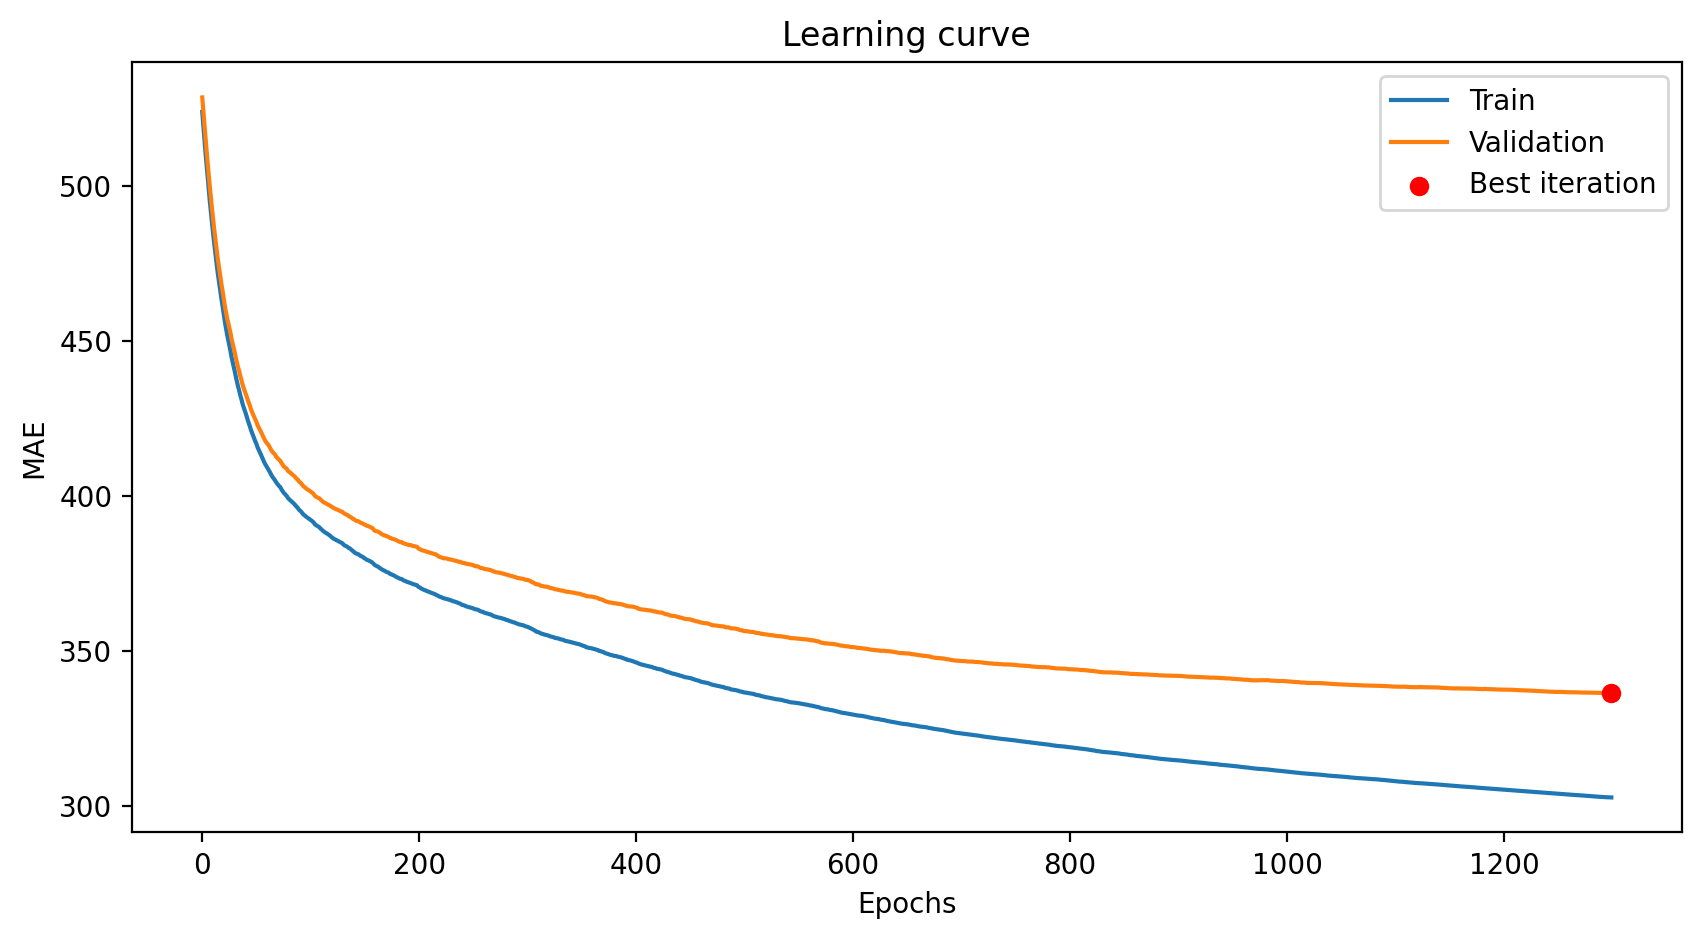

In [20]:
# Plotting learning curve
epochs = np.arange(len(results['learn']['MAE']))

# Retrieve the best iteration from the model
best_iteration = best_model.get_best_iteration()

plt.figure(figsize=(10, 5))
plt.plot(epochs, results['learn']['MAE'], label='Train')
plt.plot(epochs, results['validation']['MAE'], label='Validation')

# Mark the best iteration on the plot
if best_iteration is not None:
    plt.scatter(best_iteration, results['validation']['MAE'][best_iteration], color='red', zorder=5, label='Best iteration')

plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Learning curve')
plt.legend()
plt.show()


In [21]:
pool1 = Pool(data=X, label=y)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 

Dataset shape
dataset 1:(9416, 17)


Column names
dataset 1:
['surface_structure_coherence_mean', 'surface_structure_disorderliness_mean', 'surface_roughness_disorderliness_mean', 'colour_saturation_mean', 'colour_hue_coherence_mean', 'colour_hue_disorderliness_mean', 'tcap_wetness_mean', 'tcap_greenness_std', 'nir_band_mean', 'colour_brightness_coherence_mean', 'colour_brightness_disorderliness_mean', 'ndwi_wetness_contrast_mean', 'ndwi_wetness_coherence_std', 'tcap_wetness_disorderliness_mean', 'tcap_built_coherence_std', 'x_coord', 'y_coord']


In [22]:
# Calculation of evaluation metrics
metrics = best_model.eval_metrics(
    data=pool1,
    metrics=['RMSE','MAE', 'R2'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=False
)

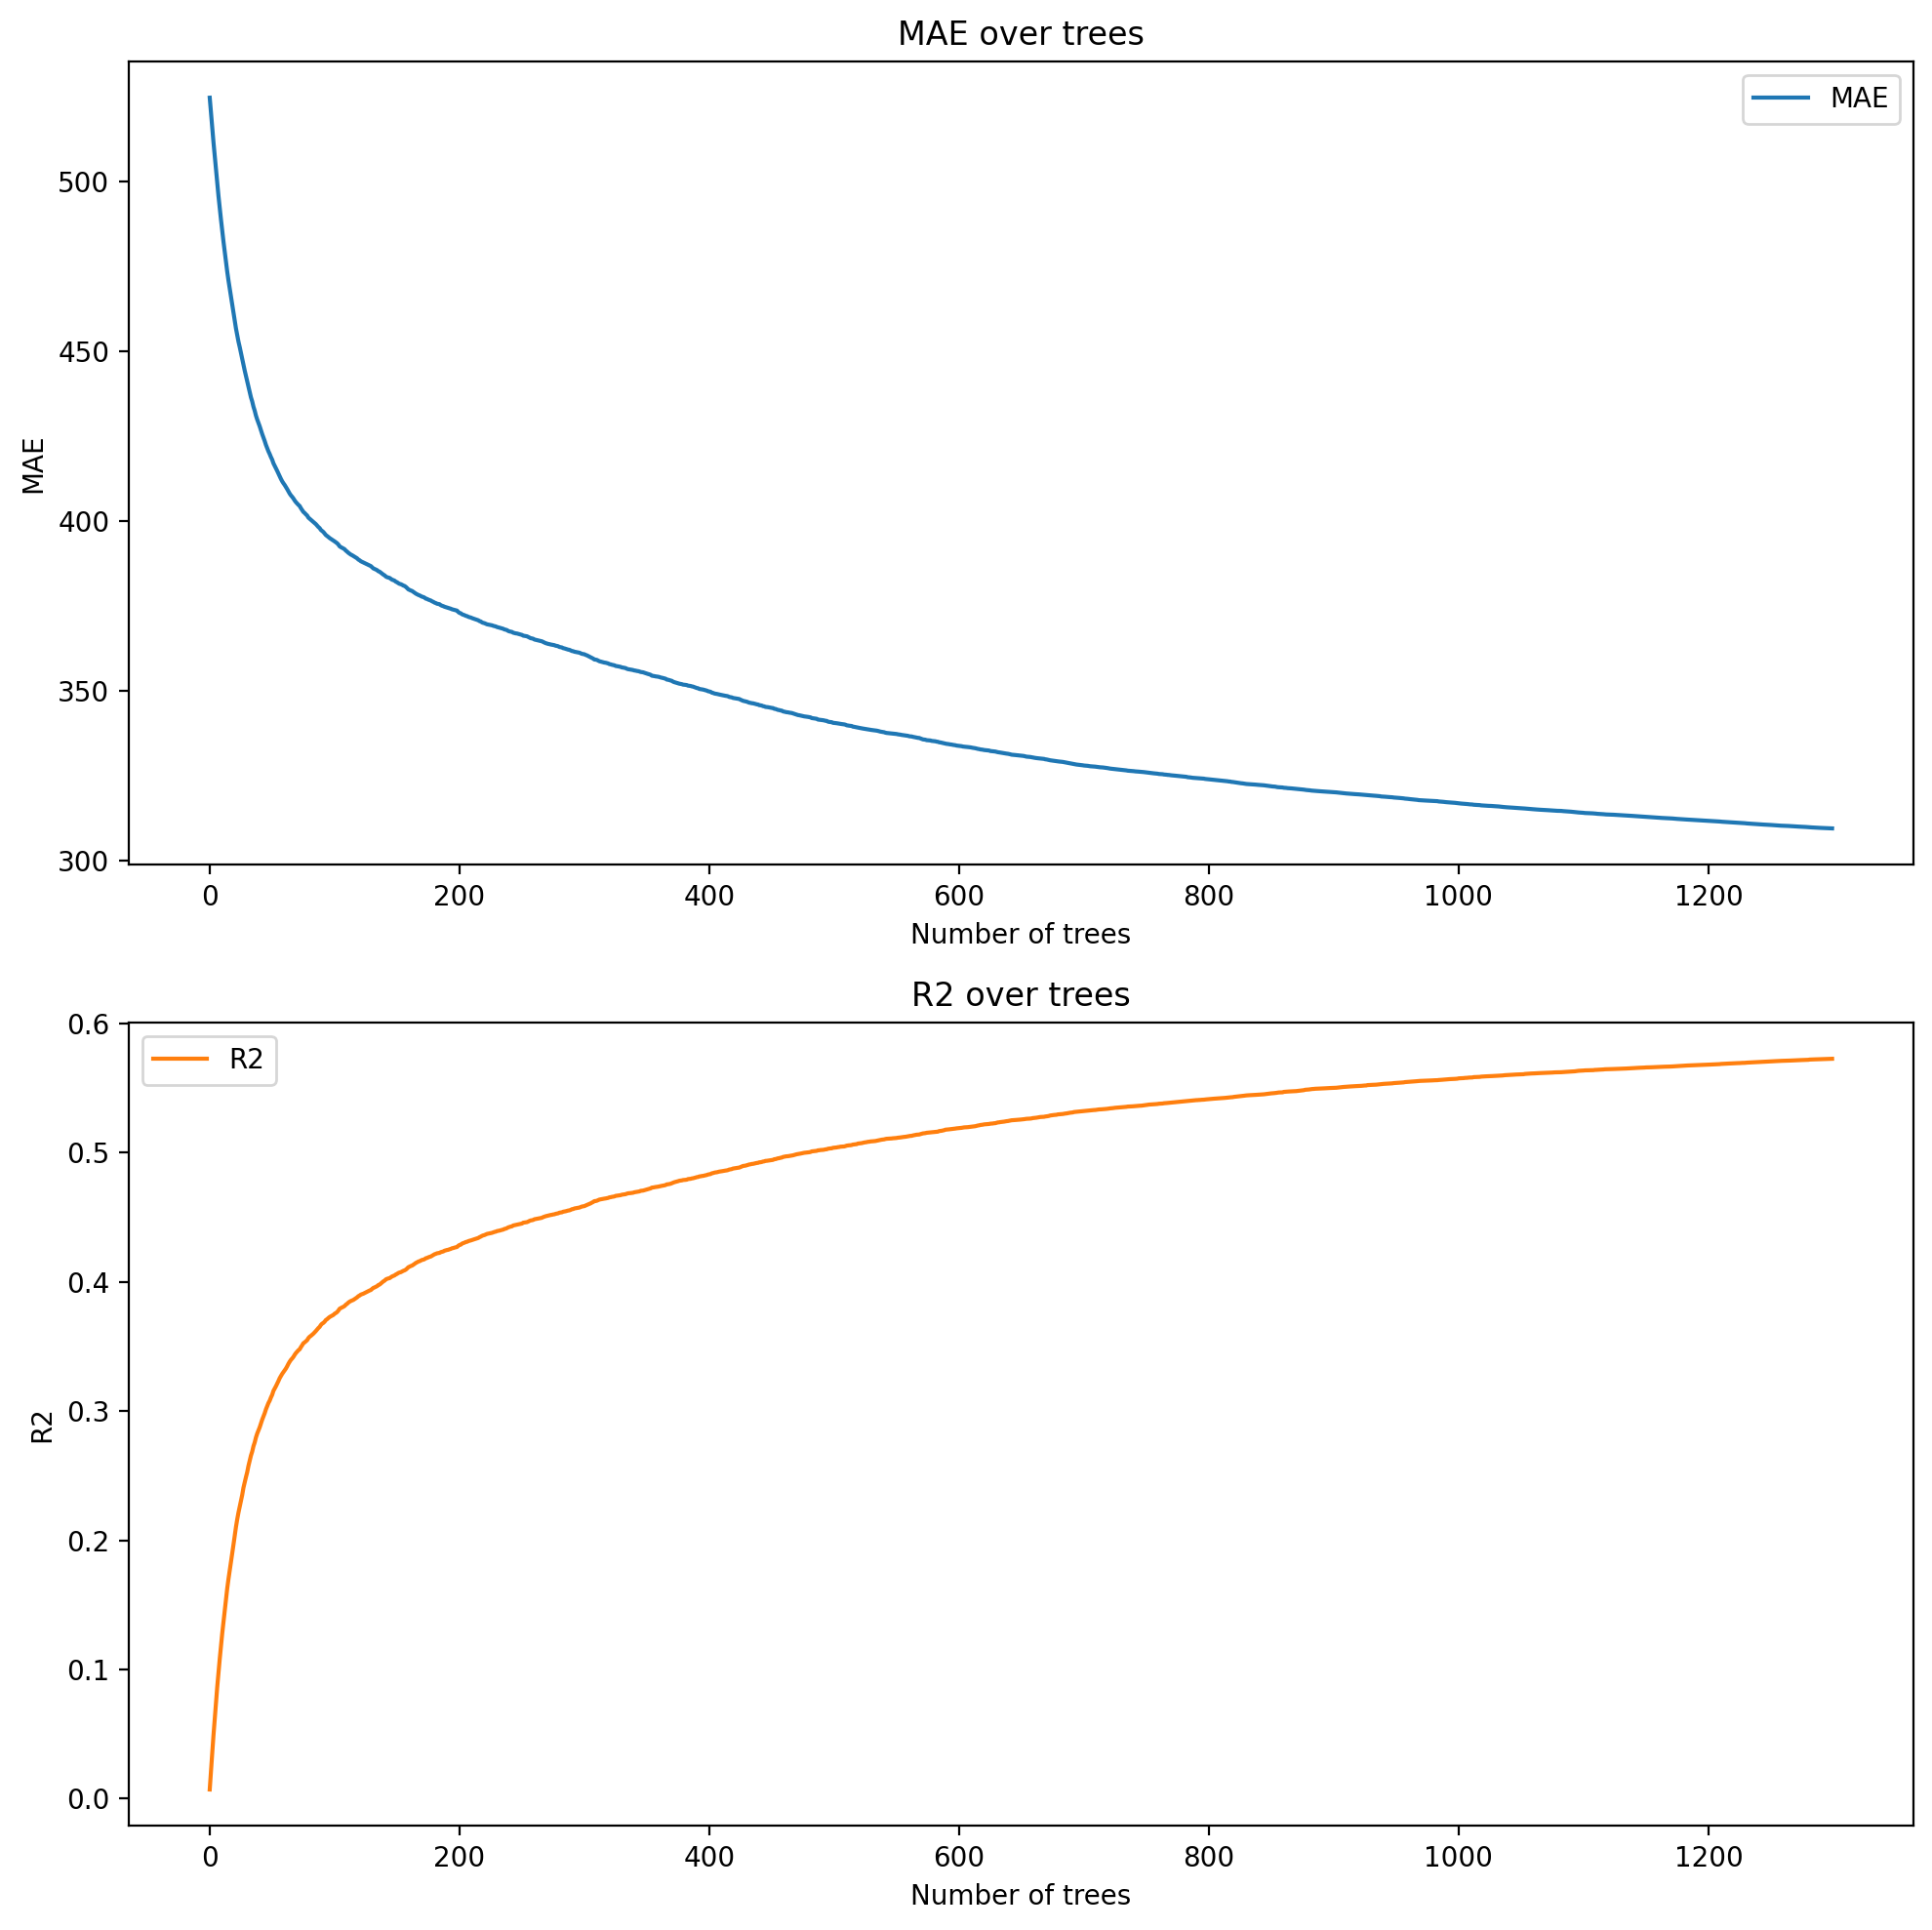

In [23]:
# Extracting metrics for plotting
rmse_values = metrics['MAE']
r2_values = metrics['R2']
trees = list(range(len(rmse_values)))  # Assuming eval_period=1 and starting from the first tree

# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plotting RMSE
axs[0].plot(trees, rmse_values, label='MAE', color='tab:blue')
axs[0].set_title('MAE over trees')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('MAE')
axs[0].legend()

# Plotting R2
axs[1].plot(trees, r2_values, label='R2', color='tab:orange')
axs[1].set_title('R2 over trees')
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('R2')
axs[1].legend()

plt.tight_layout()
plt.show()


In [24]:
# Exploring relative importance
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,x_coord,36.461285
1,y_coord,16.410224
2,tcap_wetness_mean,10.597989
3,colour_brightness_disorderliness_mean,6.398819
4,nir_band_mean,4.476556
5,surface_roughness_disorderliness_mean,4.170962
6,colour_brightness_coherence_mean,3.285235
7,ndwi_wetness_contrast_mean,3.153286
8,surface_structure_disorderliness_mean,2.794187
9,colour_saturation_mean,2.622989


In [25]:
# Get parameters from the best model but exclude 'loss_function' if it's already set
params = {key: val for key, val in best_model.get_params().items() if key != 'loss_function'}

# Define the model with optimal parameters and explicitly set the loss function and custom metric
model = CatBoostRegressor(loss_function='MAE', custom_metric='R2', **params)

# Setup Repeated K-Fold cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# Prepare lists to store results
train_r2_results = []
test_r2_results = []
train_mae_results = []
test_mae_results = []
train_rmse_results = []
test_rmse_results = []

# Loop over each fold
for train_index, test_index in rkf.split(X):
    train_pool = Pool(X.iloc[train_index], y[train_index])
    test_pool = Pool(X.iloc[test_index], y[test_index])

    # Fit model
    model.fit(train_pool, eval_set=test_pool, verbose=False)

    # Evaluate on the training set
    train_predictions = model.predict(train_pool)
    train_r2 = model.score(train_pool.get_features(), train_pool.get_label())
    train_mae = mean_absolute_error(train_pool.get_label(), train_predictions)
    train_rmse = np.sqrt(mean_squared_error(train_pool.get_label(), train_predictions))
    train_r2_results.append(train_r2)
    train_mae_results.append(train_mae)
    train_rmse_results.append(train_rmse)

    # Evaluate on the testing set
    test_predictions = model.predict(test_pool)
    test_r2 = model.score(test_pool.get_features(), test_pool.get_label())
    test_mae = mean_absolute_error(test_pool.get_label(), test_predictions)
    test_rmse = np.sqrt(mean_squared_error(test_pool.get_label(), test_predictions))
    test_r2_results.append(test_r2)
    test_mae_results.append(test_mae)
    test_rmse_results.append(test_rmse)

# Calculate the average and standard deviation of R-squared across all train and test folds
mean_train_r2 = np.mean(train_r2_results)
std_train_r2 = np.std(train_r2_results)
mean_test_r2 = np.mean(test_r2_results)
std_test_r2 = np.std(test_r2_results)

# Calculate the average and standard deviation of MAE across all train and test folds
mean_train_mae = np.mean(train_mae_results)
std_train_mae = np.std(train_mae_results)
mean_test_mae = np.mean(test_mae_results)
std_test_mae = np.std(test_mae_results)

# Calculate the average and standard deviation of RMSE across all train and test folds
mean_train_rmse = np.mean(train_rmse_results)
std_train_rmse = np.std(train_rmse_results)
mean_test_rmse = np.mean(test_rmse_results)
std_test_rmse = np.std(test_rmse_results)

print("Average Train R-squared:", mean_train_r2)
print("Train R-squared Standard Deviation:", std_train_r2)
print("Average Test R-squared:", mean_test_r2)
print("Test R-squared Standard Deviation:", std_test_r2)
print("Average Train MAE:", mean_train_mae)
print("Train MAE Standard Deviation:", std_train_mae)
print("Average Test MAE:", mean_test_mae)
print("Test MAE Standard Deviation:", std_test_mae)
print("Average Train RMSE:", mean_train_rmse)
print("Train RMSE Standard Deviation:", std_train_rmse)
print("Average Test RMSE:", mean_test_rmse)
print("Test RMSE Standard Deviation:", std_test_rmse)


Average Train R-squared: 0.5806407290198393
Train R-squared Standard Deviation: 0.003919658022257669
Average Test R-squared: 0.5358463033041496
Test R-squared Standard Deviation: 0.009684775111862698
Average Train MAE: 304.64661405634786
Train MAE Standard Deviation: 1.5265022261635453
Average Test MAE: 330.5345646369712
Test MAE Standard Deviation: 6.202463424334372
Average Train RMSE: 437.7664419443357
Train RMSE Standard Deviation: 2.2336338150444153
Average Test RMSE: 460.2955732551355
Test RMSE Standard Deviation: 8.646259430775576


In [26]:
shap_values = best_model.get_feature_importance(pool1, fstr_type='ShapValues')
print(shap_values .shape)

(9416, 18)


In [27]:
# Create a Pool object with the categorical feature specified
validation_pool = catboost.Pool(X_validation, label=y_validation)

# Calculate SHAP values
shap_values = best_model.get_feature_importance(validation_pool, type="ShapValues")

# Extract the expected value from the SHAP values output
expected_value = shap_values[0, -1]

# Exclude the expected value from the SHAP values (it's the last column)
shap_values = shap_values[:, :-1]

# Initialize JavaScript visualization in the notebook (for Jupyter Notebooks or JupyterLab)
shap.initjs()

# Create a force plot for a single prediction
shap.force_plot(expected_value, shap_values[3, :], X_validation.iloc[3, :])


In [28]:
# Create a figure and capture the plot
plt.figure()
shap.summary_plot(shap_values, X.values, plot_type="bar", feature_names=X.columns, show=False)

# Save the figure in SVG format
plt.savefig("shap_summary_plot_SYD.svg", format='svg', bbox_inches='tight')
plt.close()

In [29]:

shap.summary_plot(shap_values, X_validation, show=False)  # Set show=False to prevent it from displaying immediately

# After generating the plot, get the current figure
fig = plt.gcf()
plt.title('Impact on income in Greater Sydney')
# Save the current figure in SVG format
fig.savefig("shap_dependency_plot_SYD_17.svg", format='svg', bbox_inches='tight')

# Optionally, close the figure to free up memory
plt.close(fig)
